# Granger

> Fill in a module description here

In [ ]:
#| default_exp granger

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# NOTE: needed for python 3.10 forward compatibility with scanpy as 
# scanpy uses Iterable which is deprecated in 3.10
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [7]:
#| export
import pandas as pd, numpy as np
import importlib, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

from joblib import Parallel, delayed

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests

genes = 'wasf colq gpr1 chrm3 lmod2 tek kank3 oca2 taz map4k1'.split()
df_trj = pd.DataFrame(
    [
        np.sort(np.random.randint(0, 10, (100)))[::-1] if i % 2 == 0 else np.sort(np.random.randint(0, 10, (100)))
        for i in range(len(genes))
    ], index=genes
)
df_trj.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
wasf,9,9,9,9,9,9,9,9,9,9,...,0,0,0,0,0,0,0,0,0,0
colq,0,0,0,0,0,0,0,0,0,0,...,8,8,9,9,9,9,9,9,9,9
gpr1,9,9,9,9,9,9,9,9,9,9,...,0,0,0,0,0,0,0,0,0,0
chrm3,0,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
lmod2,9,9,9,9,9,9,9,9,9,8,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#| export

def kpss_test(series, print=False, **kwargs):
    # KPSS Null hypothesis: there is a no unit root, meaning series is stationary
    statistic, p_value, n_lags, critical_values = kpss(series, **kwargs)

    # Format Output    
    result_str = ''
    result_str += f'KPSS Statistic: {statistic}\n'
    result_str += f'p-value: {p_value}\n'
    result_str += f'num lags: {n_lags}\n'
    result_str += f'Critial Values:\n'    
    for key, value in critical_values.items():
        result_str += f'\t{key}:{value}\n'
    result_str += f'Result: The series is {"not " if p_value < 0.05 else ""}stationary'

    if print:
        print(result_str)
    return

def _add_suffix(arr, suffix:str):
    return list(map(lambda e: f'{e}_{suffix}', arr))

def _prep_args_for_granger_causality_tests(
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None,  
):
    if test is None:
        test = 'ssr_chi2test'

    if lag_order is None:
        lag_order = 1

    if max_lag is None:
        max_lag = (lag_order,)
    
    return test, lag_order, max_lag


def _ensure_no_constant_columns(
    df:pd.DataFrame, 
    copy:bool=True
):
    _SAFETY = 1e-8
    rng_mat = np.random.randn(*df.shape) * _SAFETY    
    
    # NOTE: to ensure that no column in df is constant
    df_safe = (df.copy() if copy else df) + rng_mat
    return df_safe
    

def _prep_vars_for_granger_causality_tests(
    df:pd.DataFrame, 
    x_vars=None, 
    y_vars=None,
    do_safety_check:bool=True     
):

    if do_safety_check:
        df = _ensure_no_constant_columns(df, copy=False)

    if x_vars is None:
        x_vars = df.index.values

    if y_vars is None:
        y_vars = df.index.values
    
    return df, x_vars, y_vars
    

def shift_trajectories(df:pd.DataFrame, shift:int=10, copy:bool=True) -> pd.DataFrame:
    df_trj = (df.copy() if copy else df)
    df_trj = df_trj.T[::shift]
    df_trj = df_trj - df_trj.shift(1)
    df_trj = df_trj.dropna()
    return df_trj

def get_pval_from_granger_causality_tests(
    df:pd.DataFrame,
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None, 
) -> float:
    test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)
    test_result = grangercausalitytests(df, maxlag=max_lag, verbose=False)
    p_values = [test_result[i][0][test][1] for i in max_lag]
    min_p_value = np.min(p_values)
    return min_p_value

def grangers_causation_matrix(
    df:pd.DataFrame, 
    x_vars=None, 
    y_vars=None, 
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None,    
    n_jobs:int=36
):
    
    df, x_vars, y_vars       = _prep_vars_for_granger_causality_tests(df, x_vars, y_vars)
    test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)

    delayed_funcs = [
        delayed(get_pval_from_granger_causality_tests)(
            df[[x_var, y_var]], test, lag_order, max_lag
        ) for y_var in y_vars for x_var in x_vars
    ]

    parallel_out = Parallel(n_jobs=n_jobs)(delayed_funcs)
    df_res = pd.DataFrame(
        np.array(parallel_out).reshape((len(x_vars), len(y_vars))),
        index=x_vars, columns=y_vars,        
    )
    df_res.index = _add_suffix(x_vars, 'x')
    df_res.columns = _add_suffix(y_vars, 'y')
    return df_res


def calculate_granger_causation(
    df:pd.DataFrame,    
    x_vars=None, 
    y_vars=None,
    shift:int=10,
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None,    
    n_jobs:int=-1
):     
    
    df, x_vars, y_vars       = _prep_vars_for_granger_causality_tests(df, x_vars, y_vars)    
    test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)
    
    df_trj = shift_trajectories(df, shift)
        
    df_res = grangers_causation_matrix(
        df_trj, x_vars=x_vars, y_vars=y_vars,
        test=test, lag_order=lag_order, max_lag=max_lag,
        n_jobs=n_jobs
    )

    return df_res

def apply_log2_fold(df_granger:pd.DataFrame):
    return -np.log2(df_granger + (2 ** -20))    

def apply_signed_correlation(df_tseries:pd.DataFrame, df_granger:pd.DataFrame):
    _stability = 1e-8
    var_names = df_tseries.index.values
    signed = -np.sign(df_tseries.T.corr()) * np.log(df_granger.values + _stability)
    df_res = pd.DataFrame(signed, index=var_names, columns=var_names)
    return df_res


In [ ]:
#| export
# https://scikit-learn.org/stable/auto_examples/neighbors/approximate_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-approximate-nearest-neighbors-py
class GrangerCausality(BaseEstimator):
    def __init__(
        self, 
        x_vars=None, 
        y_vars=None,
        shift:int=10,
        test:str='ssr_chi2test', 
        lag_order:int=1,
        max_lag:tuple=None, 
        n_jobs:int=-1
    ):
        '''
        Check Granger Causality of all possible combinations of the Time series.

        The rows are the response variable, columns are predictors. The values in the table 
        are the P-Values. P-Values lesser than the significance level (0.05), implies 
        the Null Hypothesis that the coefficients of the corresponding past values is 
        zero, that is, the X does not cause Y can be rejected.

        Parameters
        ----------
        test : str, default='ssr_chi2test'
            the kind of statistical test to use
        
        lag_order : int, default=1
            how long to lag
        
        max_lag : tuple, optional
        
        Notes
        -----
        lag_order
            `lag_order = 1` # becuase we got this value before. We are not suppose to add 1 to it
        
        max_lag
            `max_lag = (lag_order, )`

        See Also
        --------
        GrangerCausality._validate_args :
            validates input arguments
        '''    
        test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)
        
        self.x_vars = x_vars
        self.y_vars = y_vars
        self.shift = shift
        self.test = test
        self.max_lag = max_lag
        self.lag_order = lag_order
        self.n_jobs = n_jobs


    def fit(self, X):
        return self
    
    def transform(self, X):        
        res = None
        return res
    
    def fit_transform(self, df:pd.DataFrame):
        params = self.get_params()
        df_res = calculate_granger_causation(
            df,    
            x_vars=self.x_vars, 
            y_vars=self.y_vars,
            shift=self.shift,
            test=self.test, 
            test=self.lag_order,
            max_lag=self.max_lag,    
            n_jobs=self.n_jobs
        )
        return 


In [9]:
df_trj_s = pd.DataFrame(StandardScaler().fit_transform(df_trj.T)).T
df_trj_s.index = df_trj.index
df_trj_s

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
wasf,1.571656,1.571656,1.571656,1.571656,1.571656,1.571656,1.571656,1.571656,1.571656,1.571656,...,-1.592752,-1.592752,-1.592752,-1.592752,-1.592752,-1.592752,-1.592752,-1.592752,-1.592752,-1.592752
colq,-1.562030,-1.562030,-1.562030,-1.562030,-1.562030,-1.562030,-1.562030,-1.562030,-1.562030,-1.562030,...,1.233550,1.233550,1.582997,1.582997,1.582997,1.582997,1.582997,1.582997,1.582997,1.582997
gpr1,1.604051,1.604051,1.604051,1.604051,1.604051,1.604051,1.604051,1.604051,1.604051,1.604051,...,-1.520723,-1.520723,-1.520723,-1.520723,-1.520723,-1.520723,-1.520723,-1.520723,-1.520723,-1.520723
chrm3,-1.526858,-1.526858,-1.526858,-1.526858,-1.526858,-1.526858,-1.526858,-1.526858,-1.526858,-1.526858,...,1.447540,1.447540,1.447540,1.447540,1.447540,1.447540,1.447540,1.447540,1.447540,1.447540
lmod2,1.790727,1.790727,1.790727,1.790727,1.790727,1.790727,1.790727,1.790727,1.790727,1.445027,...,-1.320575,-1.320575,-1.320575,-1.320575,-1.320575,-1.320575,-1.320575,-1.320575,-1.320575,-1.320575
tek,-1.529739,-1.529739,-1.529739,-1.529739,-1.529739,-1.529739,-1.529739,-1.529739,-1.529739,-1.529739,...,1.717349,1.717349,1.717349,1.717349,1.717349,1.717349,1.717349,1.717349,1.717349,1.717349
kank3,1.408459,1.408459,1.408459,1.408459,1.408459,1.408459,1.408459,1.408459,1.408459,1.408459,...,-1.581195,-1.581195,-1.581195,-1.581195,-1.581195,-1.581195,-1.581195,-1.581195,-1.581195,-1.581195
oca2,-1.526564,-1.526564,-1.526564,-1.526564,-1.526564,-1.526564,-1.526564,-1.526564,-1.526564,-1.526564,...,1.460191,1.460191,1.460191,1.460191,1.460191,1.460191,1.460191,1.460191,1.460191,1.460191
taz,1.500848,1.500848,1.500848,1.500848,1.500848,1.500848,1.500848,1.500848,1.500848,1.500848,...,-1.364733,-1.722930,-1.722930,-1.722930,-1.722930,-1.722930,-1.722930,-1.722930,-1.722930,-1.722930
map4k1,-1.430683,-1.430683,-1.430683,-1.430683,-1.430683,-1.430683,-1.430683,-1.430683,-1.430683,-1.430683,...,1.549907,1.549907,1.549907,1.549907,1.549907,1.549907,1.549907,1.549907,1.549907,1.549907


<Figure size 1200x800 with 0 Axes>

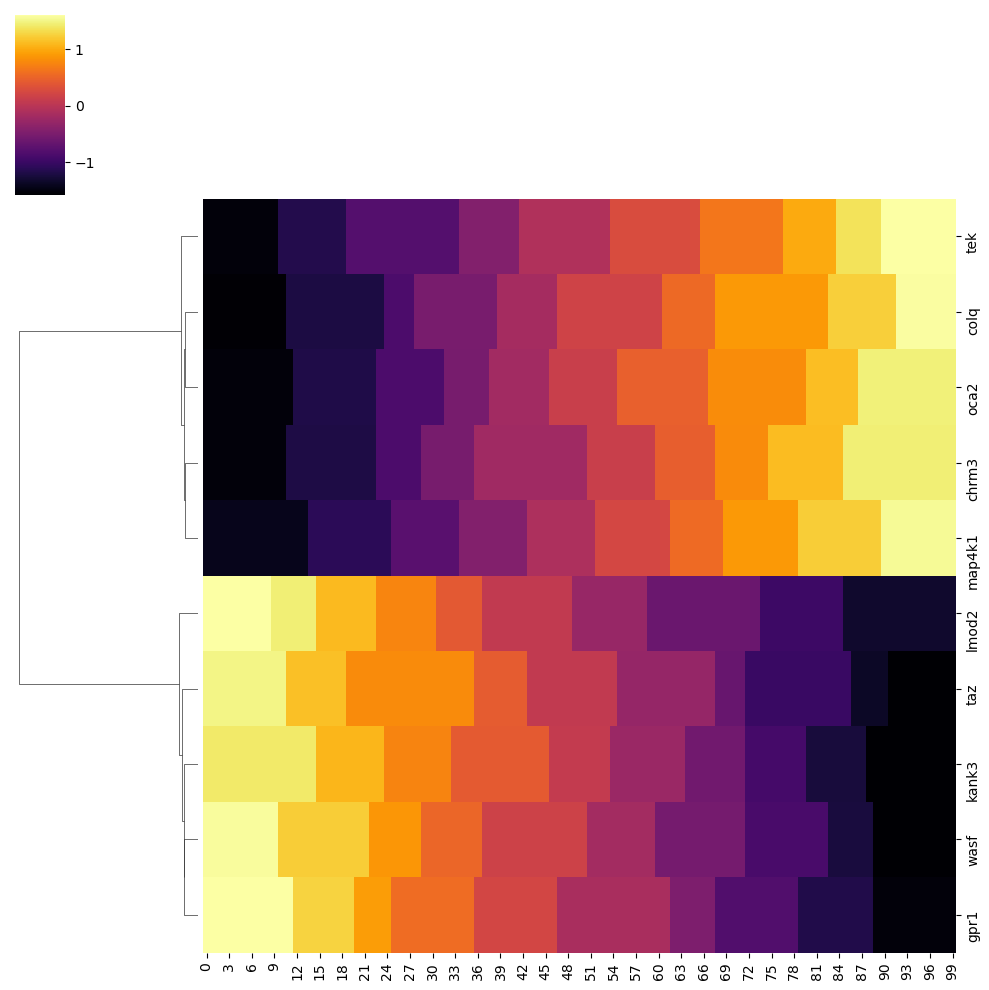

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = sns.clustermap(
    df_trj_s, cmap="inferno", robust=True,
    col_cluster=False,  yticklabels=True
)

In [11]:
res = calculate_granger_causation(df_trj_s+np.random.randn(*df_trj_s.shape), n_jobs=2)

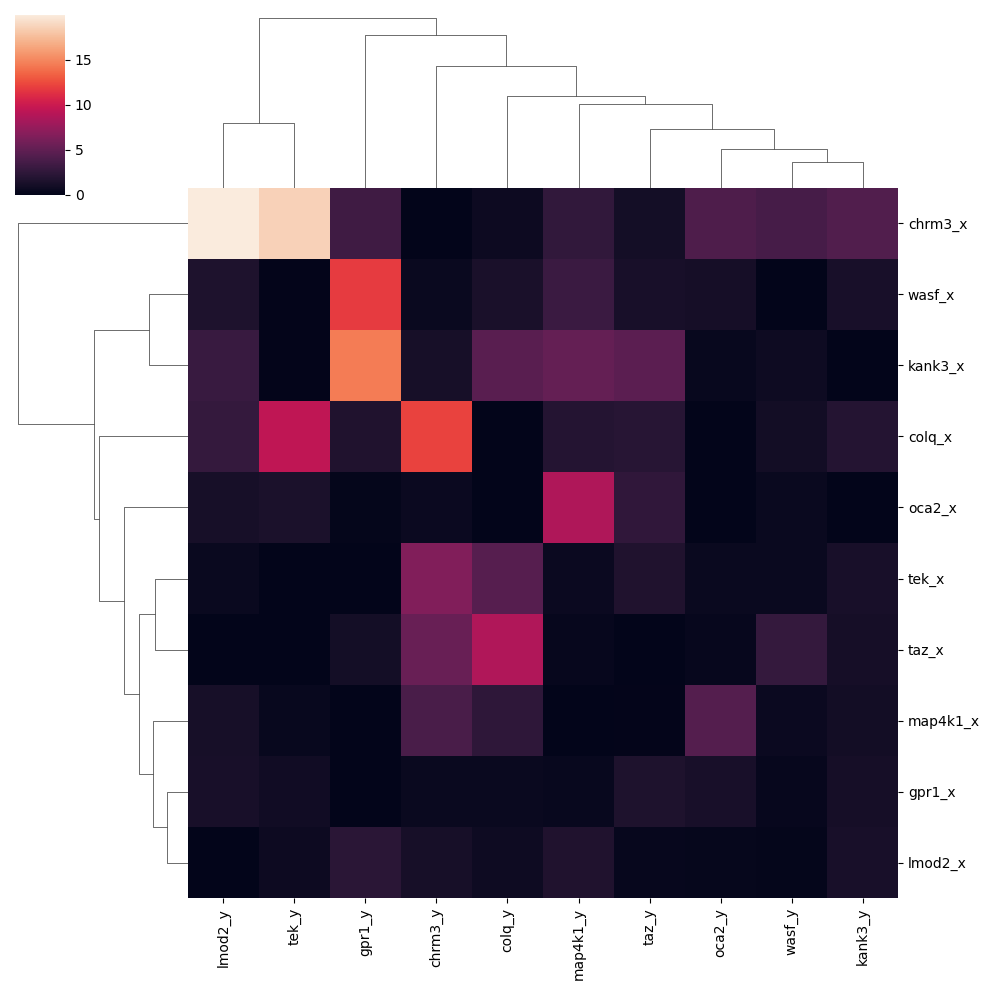

In [12]:
ax = sns.clustermap(
    apply_log2_fold(res)
)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()